<a href="https://colab.research.google.com/github/ninoc0/Layout-Parser/blob/main/layout_parser_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow 
from skimage import io
from PIL import Image 
from PIL import Image 
import matplotlib.pylab as plt 
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import pytesseract # im actually not 100% sure if all of these are needed but for some reason the code wouldn't run without them

In [34]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [35]:
!pip install -U layoutparser

In [36]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' # so this basically installs everything from the detectron in a more direct way than the tutorial shows because i read through that like 3 times and it makes no sense

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-mb4vrm6k/detectron2_473d53b4a9704fc0a5656916d99e9458
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-mb4vrm6k/detectron2_473d53b4a9704fc0a5656916d99e9458
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1


In [37]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [38]:
!pip install layoutparser[ocr]

In [39]:
%cd layout-parser/

/content/drive/MyDrive/layout-parser


In [40]:
import os, sys
from google.colab import drive
os.getcwd()
!mkdir MyDrive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")
sys.path.append("/content/drive/My Drive")
!mount --bind /content/drive/My\ Drive /content/MyDrive

mkdir: cannot create directory ‘MyDrive’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [42]:
import cv2 
image = cv2.imread('1.jpg')
image = image[..., ::-1]

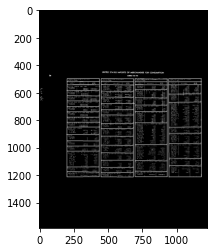

In [43]:
file=r'1.jpg'
img = cv2.imread(file,0)
img.shape
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
cv2.imwrite('cv_inverted.jpg',img_bin)
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

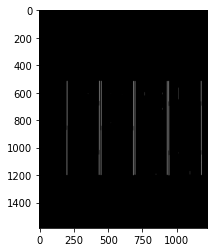

In [44]:
kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("vertical.jpg",vertical_lines)
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

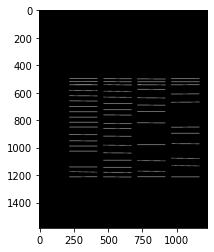

In [45]:
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("horizontal.jpg",horizontal_lines)
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

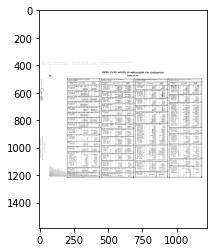

In [46]:
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [47]:
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)


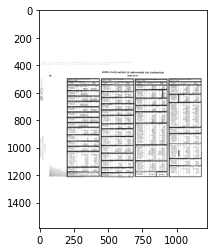

In [48]:
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

mean = np.mean(heights)

box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1100 and h<600):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
    
        
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [49]:
row=[]
column=[]
j=0

for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            
print(column)
print(row)


[[207, 501, 229, 18], [943, 502, 230, 18], [454, 502, 229, 18], [699, 504, 228, 16], [943, 523, 230, 19], [207, 523, 229, 19], [454, 524, 229, 19], [699, 525, 228, 18], [454, 545, 229, 47], [943, 546, 230, 63], [699, 546, 228, 30], [207, 547, 229, 38], [699, 580, 228, 58], [892, 584, 5, 50], [207, 587, 229, 36], [454, 593, 229, 41], [1013, 613, 160, 55], [943, 614, 67, 55], [207, 626, 229, 34], [454, 636, 229, 42], [699, 641, 228, 49], [207, 664, 229, 36], [943, 672, 231, 178], [454, 683, 229, 40], [699, 694, 228, 42], [207, 705, 228, 33], [454, 728, 229, 34], [699, 741, 228, 78], [207, 743, 228, 34], [454, 766, 229, 58], [207, 782, 228, 32], [207, 819, 228, 30], [699, 823, 228, 154], [454, 828, 229, 32], [944, 854, 230, 40], [206, 854, 229, 50], [453, 864, 229, 52], [944, 899, 231, 179], [206, 908, 229, 42], [453, 920, 229, 63], [206, 954, 229, 33], [699, 982, 228, 113], [453, 985, 229, 53], [206, 992, 229, 32], [1010, 1020, 5, 42], [206, 1029, 229, 110], [453, 1041, 229, 49], [945, 1

In [50]:
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [51]:
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
print(center)

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

[ 320  320  320  320  320  320  320  321  321  321  321  321  321  321
  321  321  321  567  567  567  567  567  567  567  568  568  568  568
  568  568  568  568  568  813  813  813  813  813  813  813  813  813
  813  888  894  976 1012 1058 1058 1058 1058 1059 1059 1060 1060 1093]


In [52]:
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [53]:
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))

In [54]:
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,CEROOTTY SERCMETION 28D UT OF GUANTITY\necmtn...,,,,,,,,,,,,,,,,,\n\nCOMADOTTT DERCRIET ON OND UNIT GF QUONTI...,,,,,,,,,,,,,,,,SOMHOOITY CERCROTION ane Ut EIT\nMEU 8 UME\n ...,,,,,,,,,,oe (aa a\neden\n,,ARGENT\n\n \n\nmETHLOS\nefacy\n,COMMOETY OETEMIFTION OND WHIT EY QUANTITY\n ...,,,,,,,,,


In [55]:
dataframe.to_csv('file1.csv')
